BiGCN
==

This is a Pytorch implementation of ***BiGCN*** model in paper:

*Predicting Emergency Medical Service Demand with Bipartite Graph Convolutional Networks*




---


## Requirements

(Recommend to run the model on ***Google Colaboratory***, which already contains many required libraries)

* Pytorch (1.4.0 or later)

* python 3.6

* networkx

* scikit-learn

* scipy

* keras-metrics

* geopandas

---

## Running



1.   Running code cell **"Environment installation & settings"** to access to your **Google Drive** and install the environment.

2.   Set the model parameters in code cell **"Global Variables & Package Import"**, and run it.

3.   Running code cell **"Read Data"** to load dataset.

4.   Running code cell **"Preprocessing"** to preprocessing dataset.

5.   Running code cell **"Function"** to set up functions used in model.

6.   Running code cell **"BiGCN Model"** to set up model.

7.   Running code cell **"Training & Testing"** to train the model, and obtain evaluation results.

8.   Change the parameters in code cell **"Global Variables & Package Import"** like Step 2, then run code cell **"Training & Testing"** for another training & evaluation.


---



Environment installation & settings

- Access to Google Drive
- Install requirement libraries

In [0]:

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

#------------------------------------------------
!mkdir -p drive
!google-drive-ocamlfuse drive
#------------------------------------------------
import os
os.chdir("drive/Ambulance") 
!ls
#------------------------------------------------
!pip install geopandas
!pip install keras-metrics
!apt-get install lshw
!lshw

Global Variables & Package Import

In [0]:
import pickle
import numpy as np
import math
import csv
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import pandas as pds

from sklearn import preprocessing

import random
import sklearn.metrics as sk
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys

sys.path.append("drive/Ambulance")
pds.set_option('display.max_columns', None)

print(sys.version)
print(torch.__version__)
CUDA = torch.cuda.is_available()    # Using GPU 


layers = 3    # Model layers
l_rate = 0.01   # learning rate
EPOCH = 500    # Epoches
dropout = 0.0   # Dropout
test_p = 0.1   # Test set percentage
val_p = 0.1    # Validation set percentage
mom = 0.9     # Momentum
batch = 100    # Print batch
alpha = 0.1    # Hyperparameters in loss function
HIDDEN = 50    # Hidden layer dimension
scale = 0.5    # L2 regularization
patience = 10    # Patience for early stopping

INFO = 0    # Print debugging information

BOUND = 0.001      # A percentage threshold regarding to hospital capacity to determine the label

LABEL_CLASS = 2     # Separate edges into binary label

#----------------Following variables will be assigned in programs----------
'''
HOS_NUM  # Number of HOS data
REG_NUM  # Number of REG data
HOS_FEA  # Feature number of HOS data
REG_FEA  # Feature number of REG data

hosNode  # List of hospital nodes
regNode  # List of region nodes

Adj_hat  # Biadjacency matrix for region node

reg_matrix   # Region feature matrix 931*15
hos_matrix   # Hospital feature matrix 291*8

label_matrix  # Label matrix

theta      # Ratio of REG_FEA in total feature number
'''

Read Data

- Distance

- Hospital/Region Node Features

In [0]:
#--------------------distance matrix---------------------------------------
'''
@dist_matrix_raw: type:numpy.array  Raw data in dist_matrix.pkl
@dist_matrix: type:numpy.array  Normalized data of dist_matrix_raw        dist_matrix = exp(-dist_matrix_raw), then normalize
'''

f = open("dist_matrix.pkl", "rb")
dist_m = pickle.load(f, encoding='utf-8')
f.close()

dist_matrix = []

for i in range(dist_m.shape[0]):
    tmp = [0]*dist_m.shape[1]
    tmp[:dist_m.shape[1]] = list(dist_m.loc[i])
    dist_matrix.append(tmp)

dist_matrix_raw = np.array(dist_matrix)

if(INFO):
    print("dist_matrix shape:", dist_m.shape)
    print("dist_matrix:", dist_m)


dist_matrix = np.exp(np.negative(dist_matrix))


if(INFO):
    print("dist_matrix max:", np.amax(dist_matrix))
    print("dist_matrix min:", np.amin(dist_matrix))
    print("dist_matrix mean:", np.mean(dist_matrix))


#--------------------------------------------Node Feature Matrix---------------------------------------
'''
@links: type:list [regNodeNumber, hosNodeNumber, totalCaseNumber, injuryCaseNumber, diseaseCaseNumber]*edgeNumber
@hosNode: type:list [hosNodeNumber]*291
@regNode: type:list [regNodeNumber]*931
@hos: type:pds [hosFeatures]*291
@reg: type:pds [regFeatures]*931

'''
links = []
weight = 2                     

f = open("node_hos_data_v2.pkl", "rb")
hos = pickle.load(f, encoding='utf-8')   #291 hospitals, and 8 features for each
f.close()

f = open("node_region_data_v2.pkl", "rb")
reg = pickle.load(f, encoding='utf-8')   # 931 regions, and 15 features for each
f.close()

f = open("link_data.csv")           # Edges and case number
lines = csv.reader(f)

flag = 1
for line in lines:
    if(flag):
        flag -= 1
        continue
    links.append(line)
    for i in range(5):
        links[-1][i] = int(links[-1][i])
f.close()

if(INFO):
    print("HOS shape:", hos.shape)
    print("HOS", hos)
    print("HOS shape:", reg.shape)
    print("REG", reg)

HOS_NUM = hos.shape[0]  # Number of HOS data
REG_NUM = reg.shape[0]  # Number of REG data
HOS_FEA = hos.shape[1]  # Feature number of HOS data
REG_FEA = reg.shape[1]  # Feature number of REG data

theta = REG_FEA*1.0/(REG_FEA+HOS_FEA)

#--------------------------------------------Create bipartite graph---------------------------------------

hosNode = []
regNode = []
edge = []
for i in links:
    regNode.append(i[0])
    hosNode.append(i[1]+1000)                 # Hospital No. starts from 1000
    edge.append((i[0], i[1]+1000, i[weight])) # Hospital No. starts from 1000

hosNode = sorted(list(set(hosNode)))          # List of hospital nodes
regNode = sorted(list(set(regNode)))          # List of region nodes
    
G = nx.Graph()
G.add_nodes_from(regNode, bipartite = 'reg')
G.add_nodes_from(hosNode, bipartite = 'hos')
G.add_weighted_edges_from(edge)
hos_nodes, reg_nodes = bipartite.sets(G)       # Set of hospital nodes
hos_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']=='hos'}
reg_nodes = set(G) - hos_nodes                 # Set of region nodes
if(INFO):
    print("G is bipartite? ", nx.is_bipartite(G))



Preprocessing

- Label processing

- Feature normalization

In [0]:
#--------------------------------------------Labels--------------------------------------------
'''
@label_m: type:numpy.array original label matrix
@label_matrix  type:numpy.array  preprocessed label matrix
'''


label_m = np.zeros((REG_NUM, HOS_NUM))

            
for i in links:
    label_m[i[0], i[1]] = i[2]            # 2: total      3: injury     4: disease

label_matrix = np.array(label_m, dtype = np.int32)


for i in range(label_matrix.shape[0]):
    for j in range(label_matrix.shape[1]):
        if(label_matrix[i,j] >= BOUND*hos.loc[j]['case_num']): #
            label_matrix[i,j] = 1
        else:
            label_matrix[i,j] = 0

Adj_hat = process_adj_hat(dist_matrix)  # Biadjacency matrix for region node

if(INFO):
    print("Rate of positive edges in adjacency matrix", np.count_nonzero(label_matrix)*1.0/(label_matrix.shape[0]*label_matrix.shape[1]))            
    print("Shape of label matrix:", label_matrix.shape)
    print("Preview of original label matrix:", label_m)
    print("Preview of label matrix:", label_matrix)


#--------------------------------------------Create feature matrix--------------------------------------------
'''
feature matrix dimensions: 1188 x (15 region features + 8 hospital features)
@reg_matrix type:numpy.array    region feature matrix
@hos_matrix type:numpy.array    hospital feature matrix
'''

reg_matrix = []       # 931*15
hos_matrix = []       # 291*8


for i in range(reg.shape[0]):
    tmp = [0]*REG_FEA
    tmp[:REG_FEA] = list(reg.loc[i])
    reg_matrix.append(tmp)
    
for i in range(hos.shape[0]):
    tmp = [0]*HOS_FEA
    tmp[:HOS_FEA] = list(hos.loc[i])
    hos_matrix.append(tmp)

reg_matrix = preprocessing.scale(reg_matrix, axis=0)
hos_matrix = preprocessing.scale(hos_matrix, axis=0)
    

if(INFO):
    print("Normalized hos matrix:", hos_matrix)

Functions

In [0]:
#--------------------------------------------Create test edges--------------------------------------------

'''
@param: Adj_hat : Biadjacency matrix for region node. size = (REG_NUM, HOS_NUM)
        test_p  : Percentage of test set, default 0.1
        val_p   : Percentage of validation set, default 0.1

@return: adj_train      : Adjacency matrix
        train_edges     : training set
        test_degree_reg : reg degree matrix(-1)
        test_degree_hos : hos degree matrix(-1)
        test_edges      : testing set
        val_edges       : validation set
'''
def test_set_create(Adj_hat, test_p = 0.1, val_p = 0.1):   
    edges_all = np.array(G.edges())
    for i in edges_all:
        i[1] -= 1000
    all_edge_idx = list(range(edges_all.shape[0]))
    np.random.shuffle(all_edge_idx)

    num_test = int(np.floor(edges_all.shape[0]*test_p)) 
    num_val = int(np.floor(edges_all.shape[0]*val_p))  

    test_edge_idx = all_edge_idx[:num_test]
    test_edges = edges_all[test_edge_idx]                               # Positive test edges
    val_edge_idx = all_edge_idx[num_test:(num_test + num_val)]
    val_edges = edges_all[val_edge_idx]                               # Positive validation edges
    train_edges = np.delete(edges_all, np.hstack([test_edge_idx, val_edge_idx]), axis=0)           # Train edges
    
    adj_train = np.array(Adj_hat)
    if(INFO):
        print("Training adjacency shape:", adj_train.shape)

    test_degree_reg = np.array(np.sum(adj_train, axis=1))
    for i in range(test_degree_reg.shape[0]):
        if(test_degree_reg[i] < 1e-6):
            test_degree_reg[i] += 1.
    test_degree_reg = np.diag(test_degree_reg.flatten())
    test_degree_reg = np.linalg.inv(test_degree_reg)

    
    test_degree_hos = np.array(np.sum(adj_train, axis=0))
    for i in range(test_degree_hos.shape[0]):
        if(test_degree_hos[i] < 1e-6):
            test_degree_hos[i] += 1.
    test_degree_hos = np.diag(test_degree_hos.flatten())
    test_degree_hos = np.linalg.inv(test_degree_hos)
    
    return adj_train, train_edges, test_degree_reg, test_degree_hos, test_edges, val_edges


'''
Transform label_matrix(shape [REG_NUM, HOS_NUM]) to One-hot encode (shape [REG_NUM*HOS_NUM, LABEL_CLASS]{0 1})
'''
def Label2Onehot(label_matrix):
    y_ = tf.reshape(label_matrix, [-1])
    return tf.one_hot(y_, LABEL_CLASS)      



'''
Transform label_matrix(shape [REG_NUM, HOS_NUM]) to SVM encode (shape [REG_NUM, HOS_NUM]{-1, 1})
'''
def Label2SVM(label_matrix):
    output = np.ones(label_matrix.shape)
    for i in range(label_matrix.shape[0]):
        for j in range(label_matrix.shape[1]):
            if(label_matrix[i,j] == 0):
                output[i,j] = -1

    return output
            


'''
@param:    pred : Predicted labels
         labels : Ground truth labels
@return:    acc : Accuracy
            pre : Precision
            rec : Recall
             f1 : F1-score
'''
def sk_score(pred, labels):
    acc = sk.accuracy_score(labels, pred)
    pre = sk.precision_score(labels, pred, average="binary")
    rec = sk.recall_score(labels, pred, average="binary")  
    f1 = sk.f1_score(labels, pred, average="binary")  

    return acc, pre, rec, f1



'''
Given the testing edges, obtain predicting labels & ground-truth labels
@param:  test_edges: test set including edges
        model: recurrent matrix given by model
         svm: True when using svm decoder
@return:  sk_score(preds, pos)
'''
def get_score(test_edges, model, svm=False):
    adj_rec = np.reshape(model, [REG_NUM, HOS_NUM])
    preds = []
    pos = []
      
    for e in test_edges:
        preds.append(adj_rec[e[0], e[1]])
        pos.append(label_matrix[e[0], e[1]])

    if(svm):
        for i in range(len(preds)):
            if(preds[i]==-1):
                preds[i] = 0

    return sk_score(preds, pos)



'''
Print dataset info
'''
def analysis_set(Name, edges_set):
    e_set = {}
    for i in range(edges_set.shape[0]):
        x_idx = edges_set[i][0]
        y_idx = edges_set[i][1]
        l = label_matrix[x_idx, y_idx]
        if(l in e_set):
            e_set[l] += 1
        else:
            e_set[l] = 1

    
    print(Name, ':')
    for key, value in e_set.items():
        print(key, ":", value)
    print("Num of edges:", len(edges_set))
    print("*********************************")



'''
Print adjacency matrix info
'''
def analysis_adj(adj_t):
    a_set = {}
    for i in range(adj_t.shape[0]):
        for j in range(adj_t.shape[1]):
            l = adj_t[i,j]
            if(l in a_set):
                a_set[l] += 1
            else:
                a_set[l] = 1

    print("Adj_hat:")
    for key, value in a_set.items():
        print(key, ":", value)




'''
Negative sampling or Positive sample or Keep origin
mode: "neg" - negative sampling (random.sample(train_list_neg, k=neg_sample))
      "pos" - positive sampling (train_list_pos*pos_scale, default=5)
      "ori" - keep original
return: sampled train set
'''
def train_set_process(train_e, mode="neg", pos_scale=5):
    train_list_pos = []
    train_list_neg = []

    for i in train_e:
        if(label_matrix[i[0], i[1]] == 1):
            train_list_pos.append(i[0]*HOS_NUM + i[1])
        else:
            train_list_neg.append(i[0]*HOS_NUM + i[1])

    neg_sample = len(train_list_pos)
    if(mode=="neg"):
        train_list = random.sample(train_list_neg, k=neg_sample)
        train_list_pos = np.array(train_list_pos)
    elif(mode=="pos"):
        train_list = train_list_neg
        train_list_pos = np.array(train_list_pos*pos_scale)
    elif(mode=="ori"):
        train_list = train_list_neg
    if(INFO):
        print("Length of train_pos & train_neg:", len(train_list_pos), len(train_list))
    train_list = np.hstack((train_list, train_list_pos))
    train_list = np.array([int(y) for y in train_list])
    np.random.shuffle(train_list)

    return train_list




'''
Calculate confusion matrix
@param:     test_edges : numpy list of testing edges
           model : recurrent matrix given by model
            svm : True when using svm decoder
'''
def get_confusion_matrix(test_edges, model, svm=False):
    adj_rec = np.reshape(model, [REG_NUM, HOS_NUM])
    preds = []
    pos = []
      
    for e in test_edges:
        preds.append(adj_rec[e[0], e[1]])
        pos.append(label_matrix[e[0], e[1]])

    if(svm):
        for i in range(len(preds)):
            if(preds[i]==-1):
                preds[i] = 0

    return sk.confusion_matrix(preds, pos)


'''
Preprocessing Adjacency matrix
'''
def process_adj_hat(Adj_hat):
    result = Adj_hat
    flag_matrix = np.zeros(Adj_hat.shape)
    for i in links:
        flag_matrix[i[0], i[1]] = 1

    for i in range(Adj_hat.shape[0]):
        for j in range(Adj_hat.shape[1]):
            if(flag_matrix[i, j] == 0):
                result[i, j] = 0

    return result


'''
Hinge loss
@param:  x: Predicted result
      y: Ground truth label
    weight: training weight parameters in SVM decoder    
'''
def hinge_loss(x, y, weight):
    loss = torch.mean(torch.clamp(1 - x*y.t(), min=0))
    loss += scale*torch.mean((weight ** 2))

    return loss

'''
Obtain labels for recurrent loss
'''
def get_new_labels():
    y = np.zeros((train_edges.shape[0]))
    for i in range(train_edges.shape[0]):
        y[i] = label_matrix[train_edges[i][0], train_edges[i][1]]
    
    if(CUDA):
        y = torch.from_numpy(y).cuda().long()
    else:
        y = torch.from_numpy(y).long()
    return y

'''
Model result visualization
@param:     epoch: Total epoch number in trainng
        Loss_list: Loss values for each epoch
        Train_accuracy_list : Training accuracy values for each epoch 
        Train_f1_list : Training f1 values for each epoch  
        Val_accuracy_list : Validation accuracy values for each epoch 
        Val_f1_list : Validation f1 values for each epoch 
'''
def visualization(epoch, Loss_list, Train_accuracy_list, Train_f1_list, Val_accuracy_list, Val_f1_list):
    x0 = range(0, epoch+1)
    x1 = range(0, epoch+1)
    x2 = range(0, epoch+1)
    x3 = range(0, epoch+1)
    x4 = range(0, epoch+1)

    y0 = Loss_list
    y1 = Train_accuracy_list
    y2 = Train_f1_list
    y3 = Val_accuracy_list
    y4 = Val_f1_list

    plt.figure(figsize=(6,4))
    plt.plot(x0, y0, '.-')
    plt.title('Train loss vs. epoches', color='white')
    plt.ylabel('Train loss', color='white')
    plt.show()

    plt.figure(figsize=(20,10))
    plt.subplot(2, 2, 1)
    plt.plot(x1, y1, '.-')
    plt.title('Train accuracy vs. epoches', color='white')
    plt.ylabel('Train accuracy', color='white')
    plt.subplot(2, 2, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Train f1 vs. epoches', color='white')
    plt.ylabel('Train f1', color='white')

    plt.subplot(2, 2, 3)
    plt.plot(x3, y3, '.-')
    plt.title('Val accuracy vs. epoches', color='white')
    plt.ylabel('Val accuracy', color='white')
    plt.subplot(2, 2, 4)
    plt.plot(x4, y4, '.-')
    plt.xlabel('Val f1 vs. epoches', color='white')
    plt.ylabel('Val f1', color='white')
    plt.show()


'''
Implementation of Early stop
Reference link: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
'''
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)


BiGCN Model

In [0]:
#----------------------GCN layers and BiGCN model------------------------

'''
BiGCN model class
    @layers: type:int   Number of GCN layers
    @hidden: type:int   Hidden layer dimension
    @train_edges: type:list List of training set edges
'''

class BiGCN(nn.Module):
    def __init__(self, layers, hidden, train_edges):
        super(BiGCN, self).__init__()
        self.layers = layers    # Layer numbers
        self.train_edges = train_edges  # Training set edges

        self.reg_gcn = nn.ModuleList([nn.Sequential(
                    nn.Linear(HOS_FEA, hidden-int(theta*hidden), bias=False),
                    nn.BatchNorm1d(hidden-int(theta*hidden), momentum=mom),
                    nn.Dropout(dropout),
                    nn.PReLU()
                )]) # GCN filtering operation for region nodes
        self.reg_omg = nn.ModuleList([nn.Sequential(
                    nn.Linear(REG_FEA, int(theta*hidden), bias=False),
                    nn.BatchNorm1d(int(theta*hidden), momentum=mom),
                    nn.Dropout(dropout),
                    nn.PReLU()
                )]) # GCN filtering operation for raw region node features
        self.hos_gcn = nn.ModuleList([nn.Sequential(
                    nn.Linear(REG_FEA, int(theta*hidden), bias=False),
                    nn.BatchNorm1d(int(theta*hidden), momentum=mom),
                    nn.Dropout(dropout),
                    nn.PReLU()
                )]) # GCN filtering operation for hospital nodes
        self.hos_omg = nn.ModuleList([nn.Sequential(
                    nn.Linear(HOS_FEA, hidden-int(theta*hidden), bias=False),
                    nn.BatchNorm1d(hidden-int(theta*hidden), momentum=mom),
                    nn.Dropout(dropout),
                    nn.PReLU()
                )]) # GCN filtering operation for raw hospital node features
        
        # Recurrent loss calculation for each layers
        self.rec_loss = nn.ModuleList([nn.Linear(HIDDEN, 1, bias=False) for i in range(self.layers-1)])
        


        self.reg_gcn.extend([nn.Sequential(
                nn.Linear(hidden, hidden-int(theta*hidden), bias=False),
                nn.BatchNorm1d(hidden-int(theta*hidden), momentum=mom),
                nn.Dropout(dropout),
                nn.PReLU()
            ) for i in range(self.layers-1)])
        
        self.reg_omg.extend([nn.Sequential(
                nn.Linear(REG_FEA, int(theta*hidden), bias=False),
                nn.BatchNorm1d(int(theta*hidden), momentum=mom),
                nn.Dropout(dropout),
                nn.PReLU()
            ) for i in range(self.layers-1)])
        
        self.hos_gcn.extend([nn.Sequential(
                nn.Linear(hidden, int(theta*hidden), bias=False),
                nn.BatchNorm1d(int(theta*hidden), momentum=mom),
                nn.Dropout(dropout),
                nn.PReLU()
            ) for i in range(self.layers-1)])

        self.hos_omg.extend([nn.Sequential(
                nn.Linear(HOS_FEA, hidden-int(theta*hidden), bias=False),
                nn.BatchNorm1d(hidden-int(theta*hidden), momentum=mom),
                nn.Dropout(dropout),
                nn.PReLU()
            ) for i in range(self.layers-1)])

        # Model parameter initialization(Using He initialization)
        for i in range(self.layers):
            nn.init.kaiming_uniform_(self.reg_gcn[i][0].weight.data)
            nn.init.kaiming_uniform_(self.reg_omg[i][0].weight.data)
            nn.init.kaiming_uniform_(self.hos_gcn[i][0].weight.data)
            nn.init.kaiming_uniform_(self.hos_omg[i][0].weight.data)
            if(i < self.layers-1):
                nn.init.kaiming_uniform_(self.rec_loss[i].weight.data)


        # Edge embedding encoder
        self.after_hadamard = nn.Sequential(
            nn.BatchNorm1d(HIDDEN, momentum=mom),
            nn.Dropout(dropout),
            nn.PReLU()
        )

        # SVM classifier decoder & initialization
        self.svm = nn.Linear(HIDDEN, 1, bias=False)
        nn.init.kaiming_uniform_(self.svm.weight.data)      
    
        self.flag = 0

    def forward(self, reg_features, reg_adjacency, reg_degree, hos_features, hos_adjacency, hos_degree):

        reg_gcn = []            # Temporal output of self.reg_gcn
        reg_omg = []            # Temporal output of self.reg_omg
        reg_emb = [reg_features]      # Temporal output of REG embeddings
        hos_gcn = []            # Temporal output of self.hos_gcn
        hos_omg = []            # Temporal output of self.hos_omg
        hos_emb = [hos_features]      # Temporal output of HOS embeddings
        rec_output = [0]*(self.layers-1)  # Saving recurrent losses



        #----------------------Node Embedding------------
        for i in range(self.layers):
            # Aggregation
            reg_gcn.append(self.reg_gcn[i](reg_degree.mm(reg_adjacency).mm(hos_emb[i])))
            reg_omg.append(self.reg_omg[i](reg_features))

            hos_gcn.append(self.hos_gcn[i](hos_degree.mm(hos_adjacency).mm(reg_emb[i])))
            hos_omg.append(self.hos_omg[i](hos_features))

            # Concatenation
            reg_emb.append(torch.cat((reg_gcn[i], reg_omg[i]), 1))
            hos_emb.append(torch.cat((hos_gcn[i], hos_omg[i]), 1))

            # Recurrent loss calculation
            if(i < self.layers-1):
                rec_y = torch.mul(reg_emb[i+1][self.train_edges[:, 0]], hos_emb[i+1][self.train_edges[:, 1]])
                rec_output[i] = self.rec_loss[i](rec_y)

        #----------------------Edge Embedding----------------
        
        for i in range(reg_emb[self.layers].size()[0]):        
            if(self.flag == 0):
                y_hat = torch.mul(hos_emb[self.layers], reg_emb[self.layers][i])
                self.flag += 1
            else:
                y_hat = torch.cat((y_hat, torch.mul(hos_emb[self.layers], reg_emb[self.layers][i])), 0)
        self.flag = 0

        y_hat = self.after_hadamard(y_hat) 

        #----------------------SVM Classifier----------------  
        y_pred = self.svm(y_hat)
        
        return y_pred, rec_output

BiGCN

Layer: 3
Label: 2
HIDDEN: 50
Train_set :
1 : 10888
0 : 7760
Num of edges: 18648
*********************************
Val_set :
0 : 992
1 : 1338
Num of edges: 2330
*********************************
Test_set :
0 : 953
1 : 1377
Num of edges: 2330
*********************************
Adj_hat:
0 : 257318
1 : 13603
Size of train edges: 18648
-------------------
Epoch: 0100 train_loss= 0.48209 val_acc= 0.83433 val_f1= 0.85912 val_pre= 0.83951 val_rec= 0.87967 train_acc= 0.84540 train_f1= 0.87054 train_precision= 0.85168 train_recall= 0.89025 time= 0.43356
Training confusion matrix: [[6530 1180]
 [1230 9708]]
[[ 791  182]
 [ 162 1195]]
Test_acc: 0.85236 Test_pre: 0.88062 Test_rec: 0.86783 Test_f1: 0.87418
Early Stopped at  166
Optimization Finished!


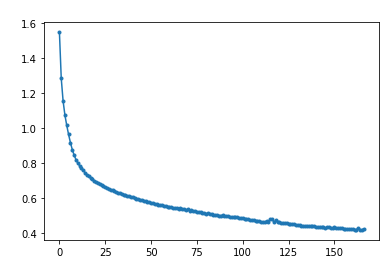

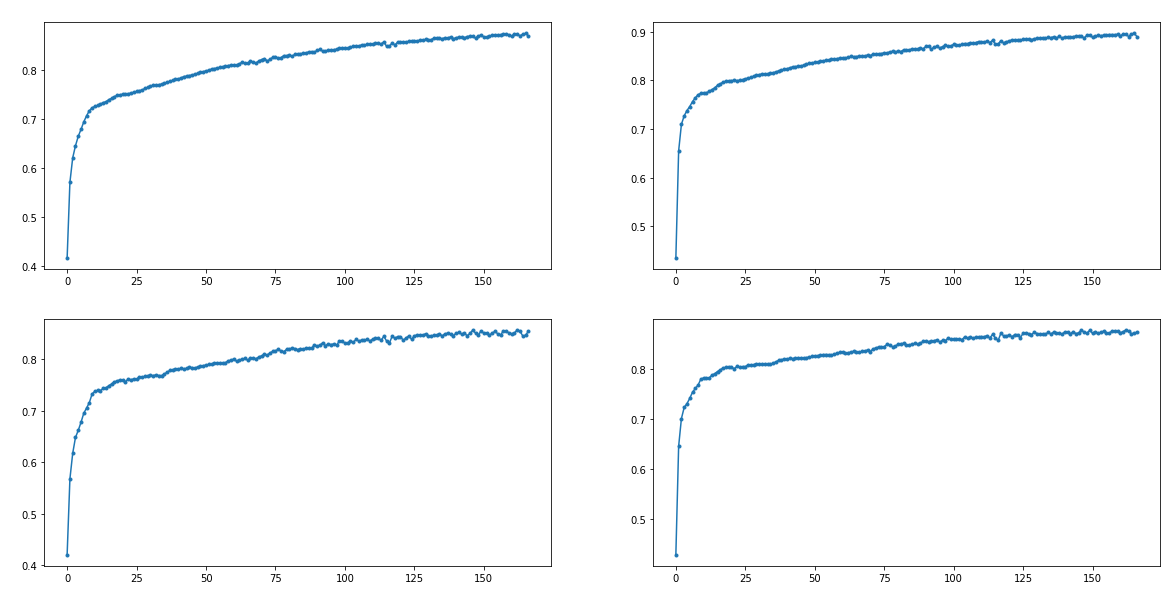

In [97]:
#--------------------------------------------Training----------------------------------


print("Layer:", layers)
print("Label:", LABEL_CLASS)
print("HIDDEN:", HIDDEN)

#--------------Dataset separation--------------
'''
@adj_train:    type: numpy.array(REG_NUM, HOS_NUM)  Biadjacency matrix for region node
@train_edges:   type: numpy.array(, 2)  Training edge sets, records the ID of two end nodes 
@test_degree_reg: type: numpy.array(REG_NUM, REG_NUM)  Diagonal degree matrix for region node
@test_degree_hos: type: numpy.array(HOS_NUM, HOS_NUM)  Diagonal degree matrix for hospital node
@test_edges:   type: numpy.array(, 2)  Testing edge sets, records the ID of two end nodes 
@val_edges:    type: numpy.array(, 2)  Validation edge sets, records the ID of two end nodes 
'''
adj_train, train_edges, test_degree_reg, test_degree_hos, test_edges, val_edges = test_set_create(Adj_hat, test_p, val_p)


#--------------Print Dataset Info--------------
analysis_set("Train_set", train_edges)
analysis_set("Val_set", val_edges)
analysis_set("Test_set", test_edges)
analysis_adj(label_matrix)

#--------------Training set processing--------------
'''
@training_set   type: numpy.array()     Training edge sets with another recording method
'''
train_set = train_set_process(train_edges, mode="ori")
print("Size of train edges:", len(train_set))



def main():
    model = BiGCN(layers, HIDDEN, train_edges)

    if(CUDA):
        torch.cuda.empty_cache()
        model.cuda()

    if(INFO):   # Pring detailed model&parameter information
        for name, param in model.named_parameters():
            print(name, param.size())
        print(model)
    y_result = train(model)

    return y_result

'''
Transforming numpy.array() variables to torch.tensor()
'''
def get_variables(reg_matrix, adj_train, test_degree_reg, hos_matrix, test_degree_hos, label_matrix):  
    reg_features = torch.from_numpy(reg_matrix).float()
    reg_adjacency = torch.from_numpy(adj_train).float()
    reg_degree = torch.from_numpy(test_degree_reg).float()
    hos_features = torch.from_numpy(hos_matrix).float()
    hos_adjacency = torch.from_numpy(np.transpose(adj_train)).float()
    hos_degree = torch.from_numpy(test_degree_hos).float()
    label = torch.from_numpy(label_matrix).long().view((-1))

    if(CUDA):
        reg_features = reg_features.cuda()
        reg_adjacency = reg_adjacency.cuda()
        reg_degree = reg_degree.cuda()
        hos_features = hos_features.cuda()
        hos_adjacency = hos_adjacency.cuda()
        hos_degree = hos_degree.cuda()
        label = label.cuda()

    return reg_features, reg_adjacency, reg_degree, hos_features, hos_adjacency, hos_degree, label


'''
Model training
'''
def train(model):
    reg_features, reg_adjacency, reg_degree, hos_features, hos_adjacency, hos_degree, label = get_variables(reg_matrix, adj_train, test_degree_reg, hos_matrix, test_degree_hos, Label2SVM(label_matrix))

    optimizer = optim.Adam(model.parameters(), lr=l_rate)

    y_true = label
    y_true_cla = label[train_set]   # Ground truth label for classification loss

    y_true_rec = get_new_labels()   # Ground truth label for recurrent loss

    Loss_list = []
    Train_accuracy_list = []
    Train_f1_list = []
    Val_accuracy_list = []
    Val_f1_list = []

    es = EarlyStopping(patience=patience)   # Early stopping trigger

    for epoch in range(EPOCH):
        model.train(mode=True)
    
        t = time.time()

        running_loss = 0.0   
        y_pred, rec_output = model(reg_features, reg_adjacency, reg_degree, hos_features, hos_adjacency, hos_degree)
        y_pred_r = y_pred[train_set]

        optimizer.zero_grad()

        loss = hinge_loss(y_true_cla, y_pred_r, model.svm.weight)
        for i in range(len(rec_output)):
            loss += alpha*hinge_loss(rec_output[i], y_true_rec, model.rec_loss[i].weight)

        loss.backward()  
        optimizer.step()
        running_loss = loss.data.cpu().numpy()

        y_t = y_true.cpu().numpy()
        y_t_r = y_true_cla.cpu().numpy()
        y_p = np.sign(y_pred.cpu().detach().numpy()).astype(np.int32)
        y_p_r = np.sign(y_pred_r.cpu().detach().numpy()).astype(np.int32)

        # Evaluate validation set
        val_acc, val_pre, val_rec, val_f1 = get_score(val_edges, y_p, svm=True)

        # Evaluate training set
        train_acc = sk.accuracy_score(y_t_r, y_p_r)
        train_pre = sk.precision_score(y_t_r, y_p_r, average="binary")
        train_rec = sk.recall_score(y_t_r, y_p_r, average="binary")
        train_f1 = sk.f1_score(y_t_r, y_p_r, average="binary")

        # Saving evaluation results for each epoch
        Loss_list.append(running_loss)
        Train_accuracy_list.append(train_acc)
        Train_f1_list.append(train_f1)
        Val_accuracy_list.append(val_acc)
        Val_f1_list.append(val_f1)


        if((epoch+1)% batch == 0):
            print("-------------------")
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(running_loss),
              "val_acc=", "{:.5f}".format(val_acc), 
              "val_f1=", "{:.5f}".format(val_f1), 
              "val_pre=", "{:.5f}".format(val_pre), 
              "val_rec=", "{:.5f}".format(val_rec),
              "train_acc=", "{:.5f}".format(train_acc),
              "train_f1=", "{:.5f}".format(train_f1),
              "train_precision=", "{:.5f}".format(train_pre),
              "train_recall=", "{:.5f}".format(train_rec),
              "time=", "{:.5f}".format(time.time() - t))
            if(CUDA):
                torch.cuda.empty_cache()

        # Evaluate testing set
        if (epoch == EPOCH-1 or es.step(running_loss)):
            model.eval()
            print("Training confusion matrix:", sk.confusion_matrix(y_p_r, y_t_r)) 
            
            test_acc, test_pre, test_rec, test_f1 = get_score(test_edges, y_p, svm=True)

            print(get_confusion_matrix(test_edges, y_p, svm=True))
            print("Test_acc:", "{:.5f}".format(test_acc), "Test_pre:", "{:.5f}".format(test_pre), 
                  "Test_rec:", "{:.5f}".format(test_rec), "Test_f1:", "{:.5f}".format(test_f1))
            


        if es.step(running_loss):
            print("Early Stopped at ", epoch)
            break  # early stop criterion is met, we can stop now
    

    print("Optimization Finished!")
    
    # Visualization
    visualization(epoch, Loss_list, Train_accuracy_list, Train_f1_list, Val_accuracy_list, Val_f1_list)
    torch.cuda.empty_cache()

    return y_pred.cpu().detach().numpy()


if __name__ == "__main__":
    y_result = main()
    

